# Init

What does this code does now?

- Reads all the .fits files from a folder, in this particular case, the ones that already have been corrected by astrometry.net.
- Substract the bias level from all the files.
- Plot instrumental magnitude vs catalogue magnitude.
- Computes airmass.
- From the plot it fits a line to compute the zero point and airmass coefficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import detect_sources
from scipy import stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from astroquery.gaia import Gaia
import pandas as pd
import subprocess
import shutil
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pathlib import Path
from scipy.stats import siegelslopes

# Load files

In [2]:
# Loading the folders that contain the fits files
#init_path = "/mnt/c/Users/catal/Downloads/Dresden_eVscope_2020/" 
#scan = os.scandir(init_path)
#folders = [f.path for f in scan if f.is_dir()]
#folders.sort()
#folders

In [2]:
init_path = Path("/mnt/c/Users/catal/Downloads/Dresden_eVscope_2020/")

solved_files = list(init_path.rglob("*.new"))

print(f"Found {len(solved_files)} solved files.")

for file in solved_files:
    with fits.open(file) as hdul:
        print(file.name, hdul[0].data.shape)

Found 6 solved files.
zuutau-2020-09-20T21-39-02.345.new (976, 1304)
zuutau-2020-09-20T21-39-22.204.new (976, 1304)
zuutau-2020-09-20T21-40-41.641.new (976, 1304)
zuutau-2020-09-20T21-49-21.073.new (976, 1304)
zuutau-2020-09-20T21-51-28.171.new (976, 1304)
zuutau-2020-09-20T22-09-04.576.new (976, 1304)


In [3]:
init_path = Path("/mnt/c/Users/catal/Downloads/Dresden_eVscope_2020/")

fits_files = list(init_path.rglob("*.new"))

#print(f"Found {len(fits_files)} FITS files.")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header

            # Extract values safely (BIASLVL might not exist in all files)
            bias = header.get("BZERO")
            exptime = header.get("EXPTIME")
            gain = header.get("GAIN")

            obs_time = Time(header["DATE-OBS"], format="isot", scale="utc")

            location = EarthLocation(
                lat=header["LATITUDE"] * u.deg,
                lon=header["LONGITUD"] * u.deg,
                height=header.get("ALTITUDE", 0) * u.m
            )

            rows.append({
                "filename": file.name,
                "bias": bias,
                "exptime": exptime,
                "gain": gain,
                "obs_time": obs_time,
                "location": location
            })

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)

print(df.head())

                             filename   bias   exptime      gain  \
0  zuutau-2020-09-20T21-39-02.345.new  32768  3.971754  0.128711   
1  zuutau-2020-09-20T21-39-22.204.new  32768  3.971754  0.128711   
2  zuutau-2020-09-20T21-40-41.641.new  32768  3.971754  0.128711   
3  zuutau-2020-09-20T21-49-21.073.new  32768  3.971754  0.128711   
4  zuutau-2020-09-20T21-51-28.171.new  32768  3.971754  0.128711   

                  obs_time                                           location  
0  2020-09-20T21:39:02.345  (3800519.387861136, 922176.0751886559, 5021683...  
1  2020-09-20T21:39:22.204  (3800519.387861136, 922176.0751886559, 5021683...  
2  2020-09-20T21:40:41.641  (3800519.387861136, 922176.0751886559, 5021683...  
3  2020-09-20T21:49:21.073  (3800519.387861136, 922176.0751886559, 5021683...  
4  2020-09-20T21:51:28.171  (3800519.387861136, 922176.0751886559, 5021683...  


## Bias substraction

In [4]:
output_path = init_path / "bias_subtracted"
output_path.mkdir(exist_ok=True)

fits_files = list(init_path.rglob("*.new"))

print(f"Processing {len(fits_files)} files...")

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)  # Convert to float for safe subtraction
            
            bias = header.get("BZERO")

            if bias is None:
                print(f"Skipping {file.name} (no BIASLVL found)")
                continue

            # Subtract bias
            corrected_data = data - bias

            # Optional: prevent negative values (if desired)
            # corrected_data[corrected_data < 0] = 0

            # Save new FITS
            new_filename = output_path / f"{file.stem}_biascorr.fits"

            fits.writeto(new_filename, corrected_data, header, overwrite=True)

            print(f"Saved: {new_filename.name}")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

Processing 6 files...
Saved: zuutau-2020-09-20T21-39-02.345_biascorr.fits
Saved: zuutau-2020-09-20T21-39-22.204_biascorr.fits
Saved: zuutau-2020-09-20T21-40-41.641_biascorr.fits
Saved: zuutau-2020-09-20T21-49-21.073_biascorr.fits
Saved: zuutau-2020-09-20T21-51-28.171_biascorr.fits
Saved: zuutau-2020-09-20T22-09-04.576_biascorr.fits


 ## Statistics of new image

In [5]:
output_path = init_path / "bias_subtracted"

fits_files = list(output_path.rglob("*.fits"))

print(f"Found {len(fits_files)} bias-subtracted images.")

rows = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            data = hdul[0].data.astype(np.float32)

            mean, median, std = sigma_clipped_stats(data, sigma=3.0)
            mode = 3 * median - 2 * mean

            rows.append({
                "filename": file.name,
                "mean": mean,
                "median": median,
                "std": std,
                "mode": mode
            })

            print(f"{file.name}: "
                  f"Mean: {mean:.3f}, "
                  f"Median: {median:.3f}, "
                  f"Std: {std:.3f}, "
                  f"Mode: {mode:.3f} ADU")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_stats = pd.DataFrame(rows)

print("\nSummary:")
print(df_stats.head())

Found 6 bias-subtracted images.
zuutau-2020-09-20T21-39-02.345_biascorr.fits: Mean: -32058.020, Median: -32080.000, Std: 411.732, Mode: -32123.961 ADU
zuutau-2020-09-20T21-39-22.204_biascorr.fits: Mean: -32057.520, Median: -32080.000, Std: 412.682, Mode: -32124.961 ADU
zuutau-2020-09-20T21-40-41.641_biascorr.fits: Mean: -32055.193, Median: -32080.000, Std: 412.577, Mode: -32129.613 ADU
zuutau-2020-09-20T21-49-21.073_biascorr.fits: Mean: -31746.537, Median: -31760.000, Std: 482.129, Mode: -31786.926 ADU
zuutau-2020-09-20T21-51-28.171_biascorr.fits: Mean: -31750.953, Median: -31776.000, Std: 480.832, Mode: -31826.094 ADU
zuutau-2020-09-20T22-09-04.576_biascorr.fits: Mean: -31216.266, Median: -31248.000, Std: 656.938, Mode: -31311.469 ADU

Summary:
                                       filename          mean   median  \
0  zuutau-2020-09-20T21-39-02.345_biascorr.fits -32058.019531 -32080.0   
1  zuutau-2020-09-20T21-39-22.204_biascorr.fits -32057.519531 -32080.0   
2  zuutau-2020-09-20T2

## Use of DAOstars to find the stars inside new image coordinates

In [6]:
output_path = init_path / "bias_subtracted"

fits_files = list(output_path.rglob("*.fits"))

print(f"Processing {len(fits_files)} WCS images.")

all_sources = []

for file in fits_files:
    try:
        with fits.open(file) as hdul:
            header = hdul[0].header
            data = hdul[0].data.astype(np.float32)

        # Build WCS
        wcs = WCS(header)

        # Compute background stats
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        mode = 3 * median - 2 * mean

        # Star detection
        daofind = DAOStarFinder(fwhm=5.0, threshold=5.0 * std)
        sources = daofind(data - mode)

        if sources is None:
            print(f"No stars found in {file.name}")
            continue

        x = sources["xcentroid"]
        y = sources["ycentroid"]

        # Convert to RA/Dec
        ra, dec = wcs.all_pix2world(x, y, 0)

        image_coords = SkyCoord(ra=ra*u.deg,
                                dec=dec*u.deg,
                                frame="icrs")

        # Store everything
        for i in range(len(sources)):
            all_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_deg": float(ra[i]),
                "dec_deg": float(dec[i]),
                "skycoord": image_coords[i]
            })

        print(f"{file.name}: detected {len(sources)} stars")

    except Exception as e:
        print(f"Error processing {file.name}: {e}")

# Convert to DataFrame
df_sources = pd.DataFrame(all_sources)

print("\nExtraction complete.")
print(df_sources.head())

Processing 6 WCS images.
zuutau-2020-09-20T21-39-02.345_biascorr.fits: detected 126 stars
zuutau-2020-09-20T21-39-22.204_biascorr.fits: detected 113 stars
zuutau-2020-09-20T21-40-41.641_biascorr.fits: detected 126 stars
zuutau-2020-09-20T21-49-21.073_biascorr.fits: detected 49 stars
zuutau-2020-09-20T21-51-28.171_biascorr.fits: detected 50 stars
zuutau-2020-09-20T22-09-04.576_biascorr.fits: detected 33 stars

Extraction complete.
                                       filename   x_centroid  y_centroid  \
0  zuutau-2020-09-20T21-39-02.345_biascorr.fits  1239.805071   19.888058   
1  zuutau-2020-09-20T21-39-02.345_biascorr.fits   331.213212   45.685589   
2  zuutau-2020-09-20T21-39-02.345_biascorr.fits   137.284751   48.343969   
3  zuutau-2020-09-20T21-39-02.345_biascorr.fits   521.562080   65.607609   
4  zuutau-2020-09-20T21-39-02.345_biascorr.fits   602.285690   68.043043   

       ra_deg    dec_deg                                           skycoord  
0  352.601755  32.290842  <SkyC

## Plot to check the matched centroids

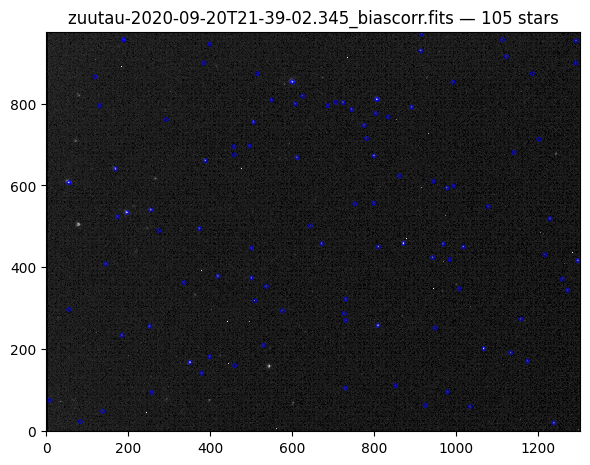

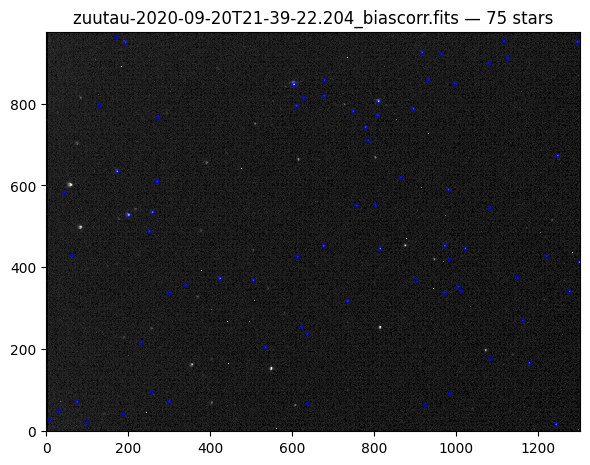

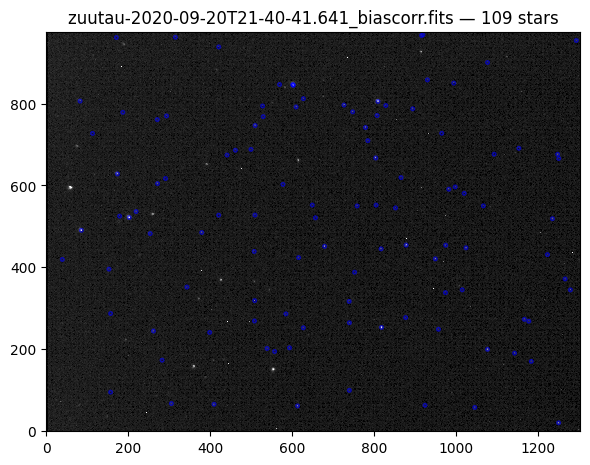

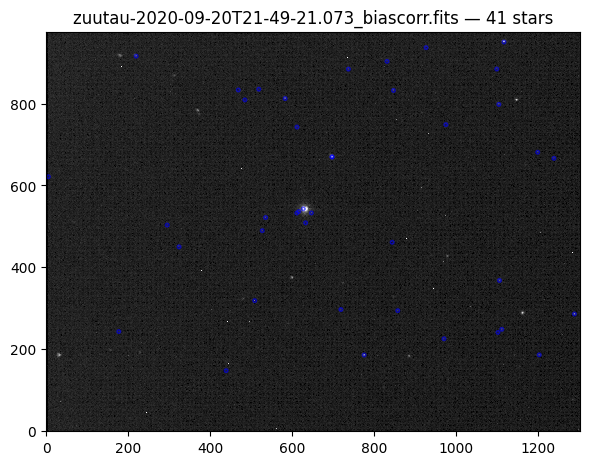

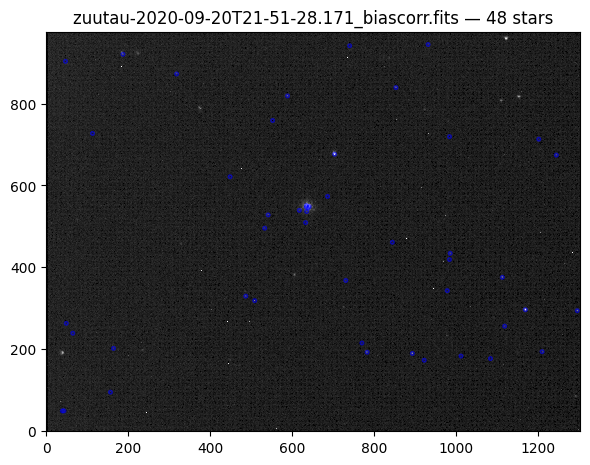

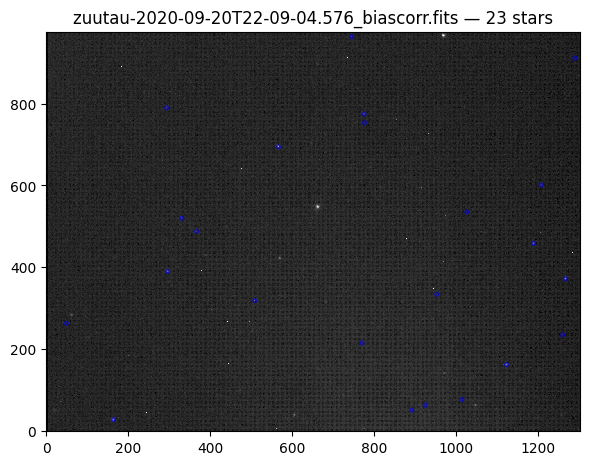

In [7]:
from photutils.aperture import CircularAperture

output_path = init_path / "bias_subtracted"
fits_files = list(output_path.rglob("*.fits"))

for file in fits_files:

    with fits.open(file) as hdul:
        data = hdul[0].data.astype(np.float32)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=4.0)

    # Plot
    plt.figure(figsize=(6, 5))
    norm = ImageNormalize(data, stretch=SqrtStretch())

    plt.imshow(data, cmap='gray', origin='lower',
               norm=norm, interpolation='nearest')

    apertures.plot(color='blue', lw=1.2, alpha=0.6)

    plt.title(f"{file.name} — {len(sources)} stars")
    plt.tight_layout()
    plt.show()

In [8]:
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection=wcs)
# ax.imshow(data_wcs, origin='lower', cmap='gray', norm=norm)
# ax.set_xlabel('Right Ascension (J2000)')
# ax.set_ylabel('Declination (J2000)')
# ax.set_title('FITS Image with WCS')
# ax.grid(color='white', ls='dotted')
# plt.show()

In [9]:
sources['real_flux'] = sources['flux'] * gain / exptime
sources['real_mag'] = 2.5 * np.log10(sources['real_flux'])
sources

/tmp/ipykernel_713286/1586333048.py:2: RuntimeWarning: invalid value encountered in log10
  sources['real_mag'] = 2.5 * np.log10(sources['real_flux'])


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,real_flux,real_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64,float32,float32
1,163.95671714274292,27.84239226887807,0.5984275458294624,-0.2641341,0.04963986044857428,25,22399.469,310466.72,-13.730038,-1.3996363836570795,10061.183,10.006622
2,892.9380882565863,51.14738337380427,0.8564311394047808,-0.06913999,-0.07168122636867001,25,7375.4688,25218.719,-11.004307,-0.6131628357180012,817.25385,7.2808924
3,925.0219270279845,63.06855703244091,0.615542777686633,-0.10065828,0.21977471232480073,25,3263.4688,17650.719,-10.616905,-0.05506470638519184,572.0004,6.8934913
4,1014.9895387610263,77.03622947915335,0.976048510626136,0.14329009,-0.0012514127414577857,25,9311.469,19890.719,-10.746626,-0.8107661353318906,644.5913,7.023211
5,1123.9377026504462,162.07057776819823,0.48135391941625716,-0.28019586,-0.34397976179360396,25,23391.469,282418.72,-13.6272335,-1.7667588737422533,9152.24,9.903818
6,771.1291390978404,215.1059371823699,0.7098858738599697,-0.5807613,-0.20261769985492317,25,4463.4688,23746.719,-10.939009,-0.1549418113243399,769.5513,7.2155943
7,1261.1780250032214,234.89856987784268,0.8880041662249653,0.06558982,0.2954681510325093,25,3855.4688,98.71875,-4.985999,-0.034531665605325,3.1991427,1.262584
8,49.050322862774486,263.02902369621677,0.8224421328084652,-0.083051294,-0.025621339762283587,25,4143.4688,5106.7188,-9.270355,-0.20476862051913444,165.49158,5.54694
9,508.9676857299061,318.4136449119283,0.7727451898105147,0.33148253,0.4740406285056151,25,14991.469,37698.72,-11.440816,-1.5145277595412434,1221.6887,7.7174015


# Gaia crossmatch

In [10]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 10000

matched_sources = []

# Loop over each bias-subtracted FITS image
for file in fits_files:

    # Open FITS
    with fits.open(file) as hdul:
        header = hdul[0].header
        data = hdul[0].data.astype(np.float32)

    # Build WCS
    wcs = WCS(header)

    # Background stats
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    mode = 3 * median - 2 * mean

    # Detect stars
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
    sources = daofind(data - mode)

    if sources is None:
        print(f"No stars found in {file.name}")
        continue

    x = sources["xcentroid"]
    y = sources["ycentroid"]
    flux = sources["flux"]
    mag_inst = sources["mag"]

    # Get exposure/gain from header (use sensible defaults if missing)
    exptime = header.get("EXPTIME", 1.0)
    gain = header.get("GAIN", 1.0)

    # Compute real flux and magnitude columns (avoid log of non-positive)
    flux_arr = np.array(flux, dtype=float)
    real_flux = flux_arr * gain / exptime
    real_mag = np.where(real_flux > 0, -2.5 * np.log10(real_flux), np.nan)

    # Convert to RA/Dec
    ra, dec = wcs.all_pix2world(x, y, 0)
    image_coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

    # Gaia query
    center_coord = SkyCoord(np.mean(ra)*u.deg, np.mean(dec)*u.deg)
    radius = 0.4 * u.deg

    print(f"Querying Gaia for {file.name}...")
    job = Gaia.cone_search_async(coordinate=center_coord, radius=radius)
    gaia_table = job.get_results()

    if len(gaia_table) == 0:
        print(f"No Gaia sources found for {file.name}")
        continue

    gaia_coords = SkyCoord(ra=gaia_table["ra"], dec=gaia_table["dec"])

    # Cross-match image stars with Gaia
    idx, sep2d, _ = image_coords.match_to_catalog_sky(gaia_coords)
    max_sep = 2.0 * u.arcsec
    good_matches = sep2d < max_sep

    for i, match in enumerate(good_matches):
        if match:
            gaia_idx = idx[i]
            matched_sources.append({
                "filename": file.name,
                "x_centroid": float(x[i]),
                "y_centroid": float(y[i]),
                "ra_image": float(ra[i]),
                "dec_image": float(dec[i]),
                "flux": float(flux[i]),
                "mag_inst": float(mag_inst[i]),
                "real_mag": float(real_mag[i]) if not np.isnan(real_mag[i]) else np.nan,
                "real_flux": float(real_flux[i]),
                "ra_gaia": gaia_table["ra"][gaia_idx],
                "dec_gaia": gaia_table["dec"][gaia_idx],
                "phot_g_mean_mag": gaia_table["phot_g_mean_mag"][gaia_idx],
                "separation_arcsec": sep2d[i].arcsec
            })

    print(f"{file.name}: {np.sum(good_matches)} matches found")

# Create DataFrame
df_matched = pd.DataFrame(matched_sources)
print(df_matched.head())

Querying Gaia for zuutau-2020-09-20T21-39-02.345_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T21-39-02.345_biascorr.fits: 81 matches found


/tmp/ipykernel_713286/2914155737.py:41: RuntimeWarning: invalid value encountered in log10
  real_mag = np.where(real_flux > 0, -2.5 * np.log10(real_flux), np.nan)


Querying Gaia for zuutau-2020-09-20T21-39-22.204_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T21-39-22.204_biascorr.fits: 58 matches found
Querying Gaia for zuutau-2020-09-20T21-40-41.641_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T21-40-41.641_biascorr.fits: 93 matches found
Querying Gaia for zuutau-2020-09-20T21-49-21.073_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T21-49-21.073_biascorr.fits: 27 matches found


/tmp/ipykernel_713286/2914155737.py:41: RuntimeWarning: invalid value encountered in log10
  real_mag = np.where(real_flux > 0, -2.5 * np.log10(real_flux), np.nan)


Querying Gaia for zuutau-2020-09-20T21-51-28.171_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T21-51-28.171_biascorr.fits: 0 matches found


/tmp/ipykernel_713286/2914155737.py:41: RuntimeWarning: invalid value encountered in log10
  real_mag = np.where(real_flux > 0, -2.5 * np.log10(real_flux), np.nan)


Querying Gaia for zuutau-2020-09-20T22-09-04.576_biascorr.fits...
INFO: Query finished. [astroquery.utils.tap.core]
zuutau-2020-09-20T22-09-04.576_biascorr.fits: 0 matches found
                                       filename   x_centroid  y_centroid  \
0  zuutau-2020-09-20T21-39-02.345_biascorr.fits  1239.763220   19.992230   
1  zuutau-2020-09-20T21-39-02.345_biascorr.fits   137.555737   48.439131   
2  zuutau-2020-09-20T21-39-02.345_biascorr.fits  1035.641368   60.032531   
3  zuutau-2020-09-20T21-39-02.345_biascorr.fits   257.644889   94.714546   
4  zuutau-2020-09-20T21-39-02.345_biascorr.fits   980.232583   95.747324   

     ra_image  dec_image           flux   mag_inst  real_mag    real_flux  \
0  352.601799  32.290804  177883.031250 -13.125336 -9.401921  5764.591226   
1  353.179954  32.478769   46699.023438 -11.673269 -7.949854  1513.358407   
2  352.716118  32.310639   48635.023438 -11.717373 -7.993958  1576.097661   
3  353.127378  32.436785   22971.023438 -10.902950 -7.179

In [12]:
df_matched.to_csv("matched_sources.csv", index=False)
df_matched

,filename,x_centroid,y_centroid,ra_image,dec_image,flux,mag_inst,real_mag,real_flux,ra_gaia,dec_gaia,phot_g_mean_mag,separation_arcsec
0,zuutau-2020-09-20T21-39-02.345_biascorr.fits,1239.763220,19.992230,352.601799,32.290804,177883.031250,-13.125336,-9.401921,5764.591226,352.601627,32.290701,12.255220,0.643240
1,zuutau-2020-09-20T21-39-02.345_biascorr.fits,137.555737,48.439131,353.179954,32.478769,46699.023438,-11.673269,-7.949854,1513.358407,353.179990,32.478913,13.866467,0.531627
2,zuutau-2020-09-20T21-39-02.345_biascorr.fits,1035.641368,60.032531,352.716118,32.310639,48635.023438,-11.717373,-7.993958,1576.097661,352.716072,32.310641,13.669188,0.139059
3,zuutau-2020-09-20T21-39-02.345_biascorr.fits,257.644889,94.714546,353.127378,32.436785,22971.023438,-10.902950,-7.179536,744.413670,353.127180,32.436484,14.503483,1.238257
4,zuutau-2020-09-20T21-39-02.345_biascorr.fits,980.232583,95.747324,352.752521,32.305106,17595.023438,-10.613475,-6.890060,570.195578,352.752734,32.304995,14.712052,0.762983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,zuutau-2020-09-20T21-49-21.073_biascorr.fits,1100.206488,884.224742,37.556530,14.061809,34625.144531,-11.348478,-7.625064,1122.084569,37.556468,14.061928,14.311487,0.479870
255,zuutau-2020-09-20T21-49-21.073_biascorr.fits,832.151283,903.054539,37.664230,14.135003,54913.144531,-11.849192,-8.125776,1779.550466,37.664240,14.135291,13.478320,1.037052
256,zuutau-2020-09-20T21-49-21.073_biascorr.fits,219.502862,915.619977,37.901150,14.313676,164449.140625,-13.040079,-9.316664,5329.243979,37.901326,14.313534,11.931717,0.801288
257,zuutau-2020-09-20T21-49-21.073_biascorr.fits,927.530424,936.453990,37.638312,14.094156,51425.144531,-11.777939,-8.054524,1666.516108,37.638356,14.094143,13.534473,0.159781


# Plot and fit of gaia stars magnitude and our stars magnitude

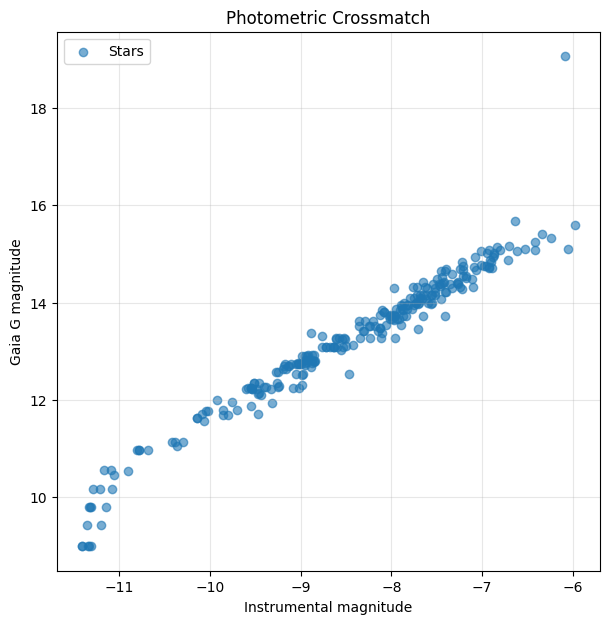

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(df_matched['real_mag'], df_matched['phot_g_mean_mag'], alpha=0.6, label='Stars')
plt.xlabel("Instrumental magnitude")
plt.ylabel("Gaia G magnitude")
plt.title("Photometric Crossmatch")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Air mass calculation 


In [18]:
airmass_list = []
delta_m_list = []


for filename in df_matched["filename"].unique():

    image_data = df_matched[df_matched["filename"] == filename]

    # Open header again to get time/location
    file_path = output_path / filename

    with fits.open(file_path) as hdul:
        header = hdul[0].header

    obs_time = Time(header["DATE-OBS"], format="isot", scale="utc")

    location = EarthLocation(
        lat=header["LATITUDE"] * u.deg,
        lon=header["LONGITUD"] * u.deg,
        height=header.get("ALTITUDE", 0) * u.m
    )

    # Rebuild sky coordinates from dataframe
    coords = SkyCoord(
        ra=image_data["ra_image"].values * u.deg,
        dec=image_data["dec_image"].values * u.deg
    )

    altaz_frame = AltAz(obstime=obs_time, location=location)
    altaz = coords.transform_to(altaz_frame)

    X = altaz.secz.value

    # Remove bad airmass
    valid = (X > 1) & (X < 5)

    X = X[valid]

    delta_m = (-image_data["real_mag"].values[valid] + image_data["phot_g_mean_mag"].values[valid]) 
    

    airmass_list.extend(X)
    delta_m_list.extend(delta_m)

# Convert to arrays
airmass = np.array(airmass_list)
delta_m = np.array(delta_m_list)

print("Total stars used:", len(airmass))


Total stars used: 259


# From theory

$$m+2.5\log{\left(\frac{F\times g}{t}\right)}=k\chi +Z_p$$

In [19]:
valid = np.isfinite(delta_m) & np.isfinite(airmass)

delta_m = delta_m[valid]
airmass = airmass[valid]

# 3-sigma clipping
mean = np.mean(delta_m)
std = np.std(delta_m)
clip = np.abs(delta_m - mean) < 3 * std

delta_m = delta_m[clip]
airmass = airmass[clip]

# linear fit
k, zp = np.polyfit(airmass, delta_m, 1)

In [20]:
clip

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,

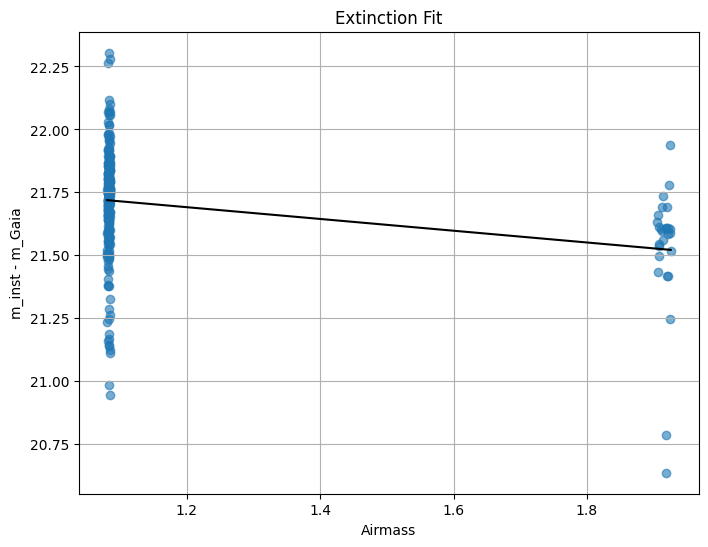

Extinction coefficient k = -0.23379011300095442
Zero point ZP = 21.9713601889223


In [21]:
plt.figure(figsize=(8,6))
plt.scatter(airmass, delta_m, alpha=0.6)
x_line = np.linspace(min(airmass), max(airmass), 100)
plt.plot(x_line, k*x_line + zp, 'k')
plt.xlabel("Airmass")
plt.ylabel("m_inst - m_Gaia")
plt.title("Extinction Fit")
plt.grid()
plt.show()

print("Extinction coefficient k =", k)
print("Zero point ZP =", zp)
